In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os

In [2]:
flagFMA = True
flagFB = False

In [3]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 128
nTurnSplit = int(nTurn/64)
errIndex = 0
betx = 1.9065054393933862
alfx = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
n_particles = 40000
nx = 100
NL_t = 0.4
NL_c = 0.01
print('singular point = ', NL_c*np.sqrt(betx))
#pipe_radius = 0.013
pipe_radius = 0.01

singular point =  0.013807626296338507


In [4]:
# H1 = 0.04005207 

# 1. Preparation

In [4]:
beam, lattice = impact.readInputFile('test_IOTA.in')

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.n_particles = n_particles

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

### 1.2. generate particles

##### 1.2.1. generate pData

In [7]:
beamtmp = copy(beam)
beamtmp.distribution.distribution_type = 'IOTA_Waterbag'
beamtmp.distribution.NL_t = NL_t
beamtmp.distribution.NL_c = NL_c
impact.writeInputFile(beamtmp,[]);
impact.run(beamtmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

##### 1.2.2. check pData

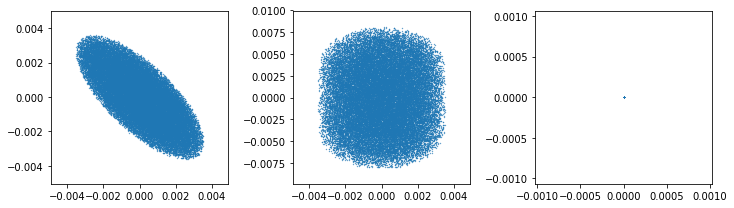

In [8]:
pData = impact.readParticleData(-111110,ke,mass,freq)
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pData[:,0],pData[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pData[:,4],pData[:,5],s=0.1)
plt.tight_layout()

##### 1.2.3. generate testP

In [9]:
testP = 0.0
sig = 0.01
k=0
q_m = beamtmp.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-0.01,0.01,nx):
    for y in np.linspace(-0.01,0.01,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            
            
pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)

nptTest= 7668


##### 1.2.4. combine pData, pTest  and Check

In [10]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

(47668, 9)


In [11]:
beam.n_particles = n_particles + nptTest
impact.writeInputFile(beam,[]);
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

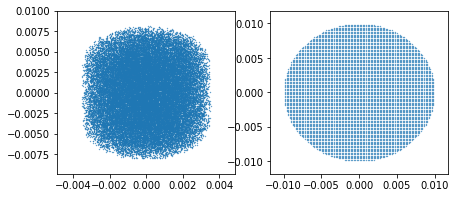

In [12]:
pDataInit = impact.readParticleData(-111110, ke, mass, freq)
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.scatter(pDataInit[nptTest:,0],pDataInit[nptTest:,2],s=0.1);
plt.subplot(1,2,2)
plt.scatter(pDataInit[:nptTest,0],pDataInit[:nptTest,2],s=0.1);

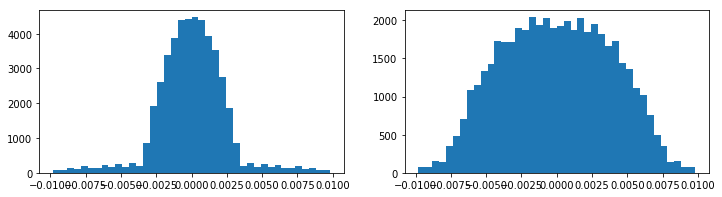

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(pDataInit[:,0],bins=40);
plt.subplot(1,2,2)
plt.hist(pDataInit[:,2],bins=40);

### 1.3 adjust lattice

In [14]:
L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = ceil(lattice[i].length*30)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_sckick = ceil(lattice[i].length*60)
            lattice[i].n_map = 5
        else:
            lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]

L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

39.968229715800106
39.968229715800106


### 1.3 adjust lattice

In [15]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode, nSample = arr.shape
    diff = np.abs(ref-arr)
    for i in range(nMode):
        for j in range(nSample):
            if (diff[i,j]>0.5):
                diff[i,j] = 1.0 - diff[i,j]
    return np.min(diff,0)

# 2. FMA

In [16]:
if flagFMA:
    print('===========================')
    print('=========== FMA ===========')
    print('===========================')

=========== FMA ===========


In [17]:
if flagFMA:
    TBT = impact.getElem('TBT')
    TBT.file_id = errIndex
    lattice.insert(1,TBT)

    TBT_integral = impact.getElem('TBT_integral')
    TBT_integral.file_id = errIndex
    TBT_integral.betx = betx
    TBT_integral.alfx = alfx
    TBT_integral.strength_t = NL_t
    TBT_integral.transverse_scale_c = NL_c
    lattice.insert(2,TBT_integral)
    
    lattice[0].turns = 2*nTurn+nTurnSplit
    for i in range(len(lattice)):
        if 'pipe_radius' in lattice[i].keys():
            lattice[i].pipe_radius = pipe_radius

In [18]:
if flagFMA:
    impact.writeInputFile(beam,lattice,'./FMA/test.in') 
    # impact.run(beam)

In [21]:
if flagFMA:
    indexTBT,TBTdataTmp = impact.readTBT(errIndex,ke,mass,freq,'./FMA/')
    indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(errIndex)
    TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2
    pDataOut= impact.readParticleData(-111111,ke,mass,freq,'/FMA')
    pDataIn = impact.readParticleData(-111110,ke,mass,freq,'/FMA')

(47668, 9)
(47668, 9)


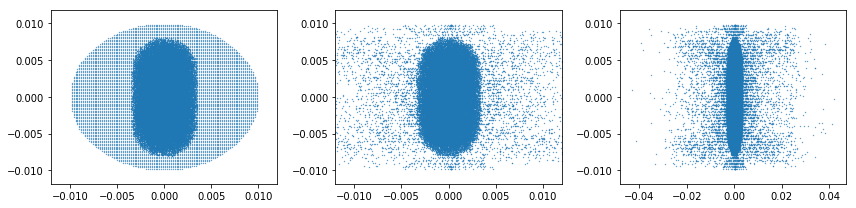

In [64]:
if flagFMA:
    print(pDataIn.shape)
    print(pDataOut.shape)
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(pDataIn[:,0],pDataIn[:,2],s=0.1)
    plt.xlim(-0.012,0.012)
    plt.subplot(1,3,2)
    plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
    plt.xlim(-0.012,0.012)
    plt.subplot(1,3,3)
    plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
    plt.tight_layout()

(32, 6, 7668)


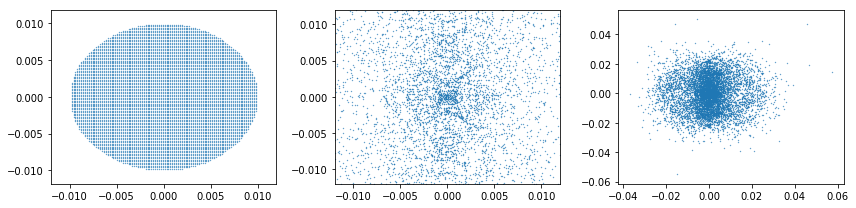

In [65]:
if flagFMA:
    print(TBTdataTmp.shape)
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(TBTdataTmp[0,0,:],TBTdataTmp[0,2,:],s=0.1)
    plt.xlim(-0.012,0.012)
    plt.subplot(1,3,2)
    plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
    plt.xlim(-0.012,0.012)
    plt.ylim(-0.012,0.012)
    plt.subplot(1,3,3)
    plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
    plt.tight_layout()

[2.12E-03 0.00E+00 7.37E-03 0.00E+00 0.00E+00 0.00E+00]


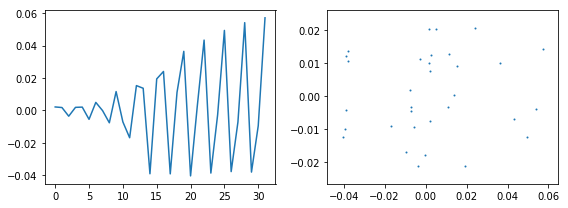

In [50]:
if flagFMA:
    nMax=np.argmax(TBTdataTmp[-1,0,:])
    print(TBTdataTmp[0,:,nMax])
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(TBTdataTmp[:,0,nMax])
    plt.subplot(1,2,2)
    plt.scatter(TBTdataTmp[:,0,nMax],TBTdataTmp[:,2,nMax],s=1)
    plt.tight_layout()

In [67]:
impact.writeParticleData(pDataOut,ke,mass,freq,'./FMA/')

In [6]:
if flagFMA:
    indexTBT,TBTdataTmp = impact.readTBT(errIndex,ke,mass,freq,'./FMA/')
    indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(errIndex)
    TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2
    pDataOut= impact.readParticleData(-111111,ke,mass,freq,'/FMA')
    pDataIn = impact.readParticleData(-111110,ke,mass,freq,'/FMA')

(47668, 9)
(47668, 9)


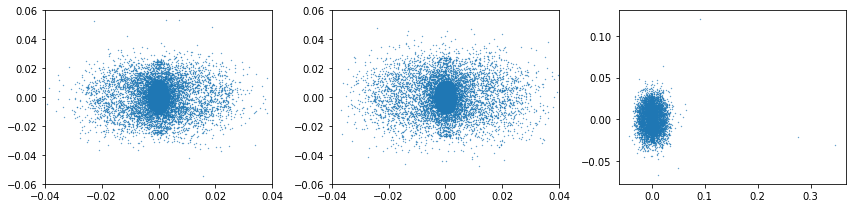

In [16]:
if flagFMA:
    print(pDataIn.shape)
    print(pDataOut.shape)
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(pDataIn[:,0],pDataIn[:,2],s=0.1)
    plt.xlim(-0.04,0.04)
    plt.ylim(-0.06,0.06)
    plt.subplot(1,3,2)
    plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
    plt.xlim(-0.04,0.04)
    plt.ylim(-0.06,0.06)
    plt.subplot(1,3,3)
    plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
    plt.tight_layout()

(32, 6, 7668)


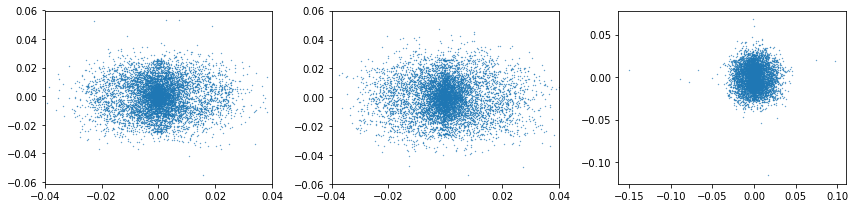

In [15]:
if flagFMA:
    print(TBTdataTmp.shape)
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(TBTdataTmp[0,0,:],TBTdataTmp[0,2,:],s=0.1)
    plt.xlim(-0.04,0.04)
    plt.subplot(1,3,2)
    plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
    plt.xlim(-0.04,0.04)
    plt.ylim(-0.06,0.06)
    plt.subplot(1,3,3)
    plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
    plt.tight_layout()

[-4.31E-02 1.61E-02 -2.28E-02 2.15E-03 -4.96E-01 0.00E+00]


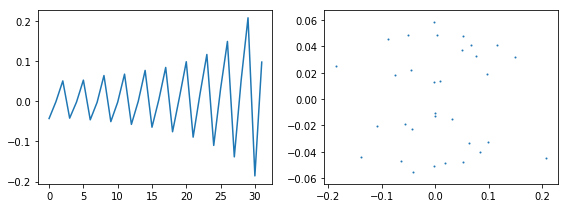

In [9]:
if flagFMA:
    nMax=np.argmax(TBTdataTmp[-1,0,:])
    print(TBTdataTmp[0,:,nMax])
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(TBTdataTmp[:,0,nMax])
    plt.subplot(1,2,2)
    plt.scatter(TBTdataTmp[:,0,nMax],TBTdataTmp[:,2,nMax],s=1)
    plt.tight_layout()

In [ ]:
if flagFMA:
    iLost,iLive = getArgLostLive(TBTdataTmp,rad=2.0*xmax*np.sqrt(2.0))
    nptLive = len(iLive)
    nptLost = len(iLost)
    TBTdata = TBTdataTmp[:,:,iLive]
    print('TBTdata.shape =',TBTdata.shape)
    print('nptLost,nptLive =',nptLost,nptLive)

In [ ]:
if flagFMA:
    indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(errIndex)
    # back to Chad's definition of I2
    TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2
    TBTdata_Inv = TBTdataTmp_Inv[:,:,iLive]
    print('TBTdata_Inv.shape',TBTdata_Inv.shape)

In [ ]:
if flagFMA:
    X = TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:])
    Y = TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:])
    tuneXbefore= np.zeros([1,nptLive])
    tuneXafter = np.zeros([3,nptLive])
    tuneYbefore= np.zeros([1,nptLive])
    tuneYafter = np.zeros([3,nptLive])
    for i in range(nptLive):
        tuneXbefore[:,i],amp = impact.util.naff(1,X[:nTurn,i],window_id=1)
        tuneXafter [:,i],amp = impact.util.naff(3,X[nTurn+nTurnSplit:,i],window_id=1)
        tuneYbefore[:,i],amp = impact.util.naff(1,Y[:nTurn,i],window_id=1)
        tuneYafter [:,i],amp = impact.util.naff(3,Y[nTurn+nTurnSplit:,i],window_id=1)

In [ ]:
if flagFMA:
    Xdiff = getClosestDiff(tuneXbefore,tuneXafter)
    Ydiff = getClosestDiff(tuneYbefore,tuneYafter)
    Adiff = np.sqrt(Xdiff**2 +Ydiff**2)

    Xstd = np.std(Xdiff)
    Ystd = np.std(Ydiff)
    Astd = np.sqrt(Xstd**2+Ystd**2)

    AdiffLog = np.log10(Adiff+1.0e-6)
    XdiffLog = np.log10(Xdiff+1.0e-6)
    YdiffLog = np.log10(Ydiff+1.0e-6)

    iMaxX = np.argmax(Xdiff)
    iMaxY = np.argmax(Ydiff)
    iMaxA = np.argmax(Adiff)
    iMinX = np.argmin(Xdiff)
    iMinY = np.argmin(Ydiff)
    iMinA = np.argmin(Adiff)

    XdiffSig= 1.0/(1+np.exp(-0.5*(Xdiff-np.mean(Xdiff))/Xstd))
    YdiffSig= 1.0/(1+np.exp(-0.5*(Ydiff-np.mean(Ydiff))/Ystd))
    AdiffSig= 1.0/(1+np.exp(-0.5*(Adiff-np.mean(Adiff))/Astd))